# Notebook 03: Feature Engineering

**Mục tiêu:** Chuyển đổi các cặp dữ liệu `(Query, Candidate)` thành vector đặc trưng số học (Feature Vectors).

**Đầu vào:** `train_augmented.pkl` (từ Notebook 02).
**Đầu ra:** `train_features.pkl` (DataFrame chứa các cột feature X và nhãn y).

**Danh sách Features:**
1.  **ID Group:** `id_match_score` (Quan trọng nhất).
2.  **Title Group:** `title_fuzzy`, `title_cosine`, `title_token_sort`, `title_len_diff`.
3.  **Author Group:** `auth_jaccard`, `first_auth_match`, `auth_count_diff`.
4.  **Year Group:** `year_diff`.

In [10]:
import pandas as pd
import numpy as np
import os
import sys

# Setup path để import src module
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import từ src.ml module
from src.ml import (
    load_pickle,
    save_pickle,
    # Feature functions
    normalize_text_basic,
    get_tokens,
    safe_year_diff,
    compute_pairwise_features,
    compute_tfidf_cosine_batch,
    extract_features_batch,
    analyze_feature_correlation,
    get_feature_columns
)

# --- CẤU HÌNH ---
INPUT_FILE = '../../dataset_final/clean_data/train_augmented.pkl'
OUTPUT_FILE = '../../dataset_final/clean_data/train_features.pkl'

print("✅ Import modules thành công từ src.ml!")

✅ Import modules thành công từ src.ml!



## 1. Load dữ liệu & Chuẩn bị
Load file pickle từ bước Data Augmentation.


In [11]:
# Load dữ liệu sử dụng hàm từ module
if not os.path.exists(INPUT_FILE):
    raise FileNotFoundError(f"❌ Không tìm thấy file: {INPUT_FILE}. Hãy chạy Notebook 02 trước.")

df = load_pickle(INPUT_FILE)
print(f"Tổng số mẫu dữ liệu: {len(df)}")
print(f"Phân bố nhãn: \n{df['label'].value_counts()}")

Tổng số mẫu dữ liệu: 51375
Phân bố nhãn: 
label
0    41100
1    10275
Name: count, dtype: int64



## 2. Định nghĩa các hàm trích xuất Feature
### 2.1. Helper Functions (Xử lý text)

In [12]:
# Các hàm helper đã được import từ src.ml.features:
# - normalize_text_basic(): Chuẩn hóa text
# - get_tokens(): Chuyển text thành set tokens
# - safe_year_diff(): Tính khoảng cách năm

print("📚 Các hàm Helper đã import từ src.ml:")
print("   - normalize_text_basic(text) -> str")
print("   - get_tokens(text_or_list) -> set")
print("   - safe_year_diff(y1, y2) -> int")

📚 Các hàm Helper đã import từ src.ml:
   - normalize_text_basic(text) -> str
   - get_tokens(text_or_list) -> set
   - safe_year_diff(y1, y2) -> int


### 2.2. Feature Extraction Logic (Core)


In [13]:
# Hàm compute_pairwise_features đã được import từ src.ml.features
# Hàm này tính toán tất cả các features cho một cặp (Query, Candidate)

print("📚 Hàm compute_pairwise_features đã import từ src.ml")
print("   Features được tính:")
print("   - feat_id_match: ID matching score (0, 0.8, 1.0)")
print("   - feat_title_fuzzy: Fuzzy ratio")
print("   - feat_title_sort: Token sort ratio")
print("   - feat_title_partial: Partial ratio")
print("   - feat_title_contain: Title containment")
print("   - feat_title_len_diff: Length difference")
print("   - feat_auth_jaccard: Author Jaccard")
print("   - feat_auth_overlap: Author overlap count")
print("   - feat_auth_token_sort: Author token sort")
print("   - feat_first_auth_match: First author match")
print("   - feat_year_diff: Year difference")
print("   - feat_year_match: Exact year match")

📚 Hàm compute_pairwise_features đã import từ src.ml
   Features được tính:
   - feat_id_match: ID matching score (0, 0.8, 1.0)
   - feat_title_fuzzy: Fuzzy ratio
   - feat_title_sort: Token sort ratio
   - feat_title_partial: Partial ratio
   - feat_title_contain: Title containment
   - feat_title_len_diff: Length difference
   - feat_auth_jaccard: Author Jaccard
   - feat_auth_overlap: Author overlap count
   - feat_auth_token_sort: Author token sort
   - feat_first_auth_match: First author match
   - feat_year_diff: Year difference
   - feat_year_match: Exact year match



## 3. Áp dụng Feature Extraction (Batch Processing)

*Lưu ý:* Để tính TF-IDF Cosine Similarity hiệu quả, ta nên làm trên toàn bộ batch thay vì từng dòng lẻ tẻ.


In [14]:
from tqdm import tqdm
tqdm.pandas()

# Sử dụng hàm extract_features_batch từ module (bao gồm cả TF-IDF)
print("🚀 Đang tính toán Features (sử dụng src.ml.features)...")

# Tính features cơ bản (row-by-row)
basic_features_df = df.progress_apply(
    lambda row: pd.Series(compute_pairwise_features(row)), 
    axis=1
)

# Ghép features vào DataFrame gốc
df_features = pd.concat([df, basic_features_df], axis=1)

print(f"✅ Đã tính xong {len(basic_features_df.columns)} features cơ bản")

🚀 Đang tính toán Features (sử dụng src.ml.features)...


100%|██████████| 51375/51375 [02:00<00:00, 426.36it/s] 

✅ Đã tính xong 12 features cơ bản



### Tính bổ sung TF-IDF Cosine Similarity (Vectorized)
TF-IDF giúp bắt các từ khóa quan trọng (như tên thuật toán, tên chất hóa học) tốt hơn Fuzzy Matching.


In [15]:
# Sử dụng hàm compute_tfidf_cosine_batch từ module
print("🚀 Đang tính toán TF-IDF Cosine Similarity...")

cosine_sims = compute_tfidf_cosine_batch(df, query_col='bib_title', cand_col='cand_title')
df_features['feat_title_tfidf_cosine'] = cosine_sims

print(f"✅ Đã tính xong TF-IDF Cosine cho {len(cosine_sims)} cặp")

🚀 Đang tính toán TF-IDF Cosine Similarity...
✅ Đã tính xong TF-IDF Cosine cho 51375 cặp


## 4. Kiểm tra và Lưu kết quả
Kiểm tra sự tương quan giữa các Feature và Nhãn để xem Feature nào "xịn".

In [16]:
# Sử dụng hàm analyze_feature_correlation từ module
print("\n--- Feature Analysis (Correlation with Label) ---")

feature_cols = get_feature_columns(df_features)
correlation = analyze_feature_correlation(df_features)
print(correlation)

# Lưu kết quả
final_cols = ['label'] + feature_cols
df_features[final_cols].to_pickle(OUTPUT_FILE)

print(f"\n✅ Đã lưu Feature Matrix tại: {os.path.abspath(OUTPUT_FILE)}")
print(f"   - Số lượng dòng: {len(df_features)}")
print(f"   - Số lượng Features: {len(feature_cols)}")


--- Feature Analysis (Correlation with Label) ---
label                      1.000000
feat_title_contain         0.753787
feat_title_tfidf_cosine    0.732682
feat_auth_jaccard          0.698327
feat_title_fuzzy           0.608468
feat_title_sort            0.580153
feat_auth_token_sort       0.571873
feat_title_partial         0.549878
feat_first_auth_match      0.450197
feat_year_match            0.447998
feat_auth_overlap          0.413515
feat_id_match              0.217457
feat_title_len_diff       -0.183671
feat_year_diff            -0.275479
Name: label, dtype: float64

✅ Đã lưu Feature Matrix tại: d:\Coding\School\Y3-K1\Intro2DS\DS - LAB 2\Milestone2_Project\dataset_final\clean_data\train_features.pkl
   - Số lượng dòng: 51375
   - Số lượng Features: 13


## 5. Trực quan hóa & Đánh giá Feature (QUAN TRỌNG)

Bước này giúp ta trả lời câu hỏi: *"Feature này có giúp phân biệt được Match và Non-Match không?"*
* **Kỳ vọng:** Đường màu cam (Match) và màu xanh (Non-Match) phải tách biệt nhau càng xa càng tốt.
* **Thực tế:** Nếu 2 đường chồng lên nhau, feature đó yếu.


C:\Users\duyla\AppData\Local\Temp\ipykernel_3540\3948434368.py:24: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_features, x=col, hue='label', fill=True, ax=axes[i], common_norm=False)


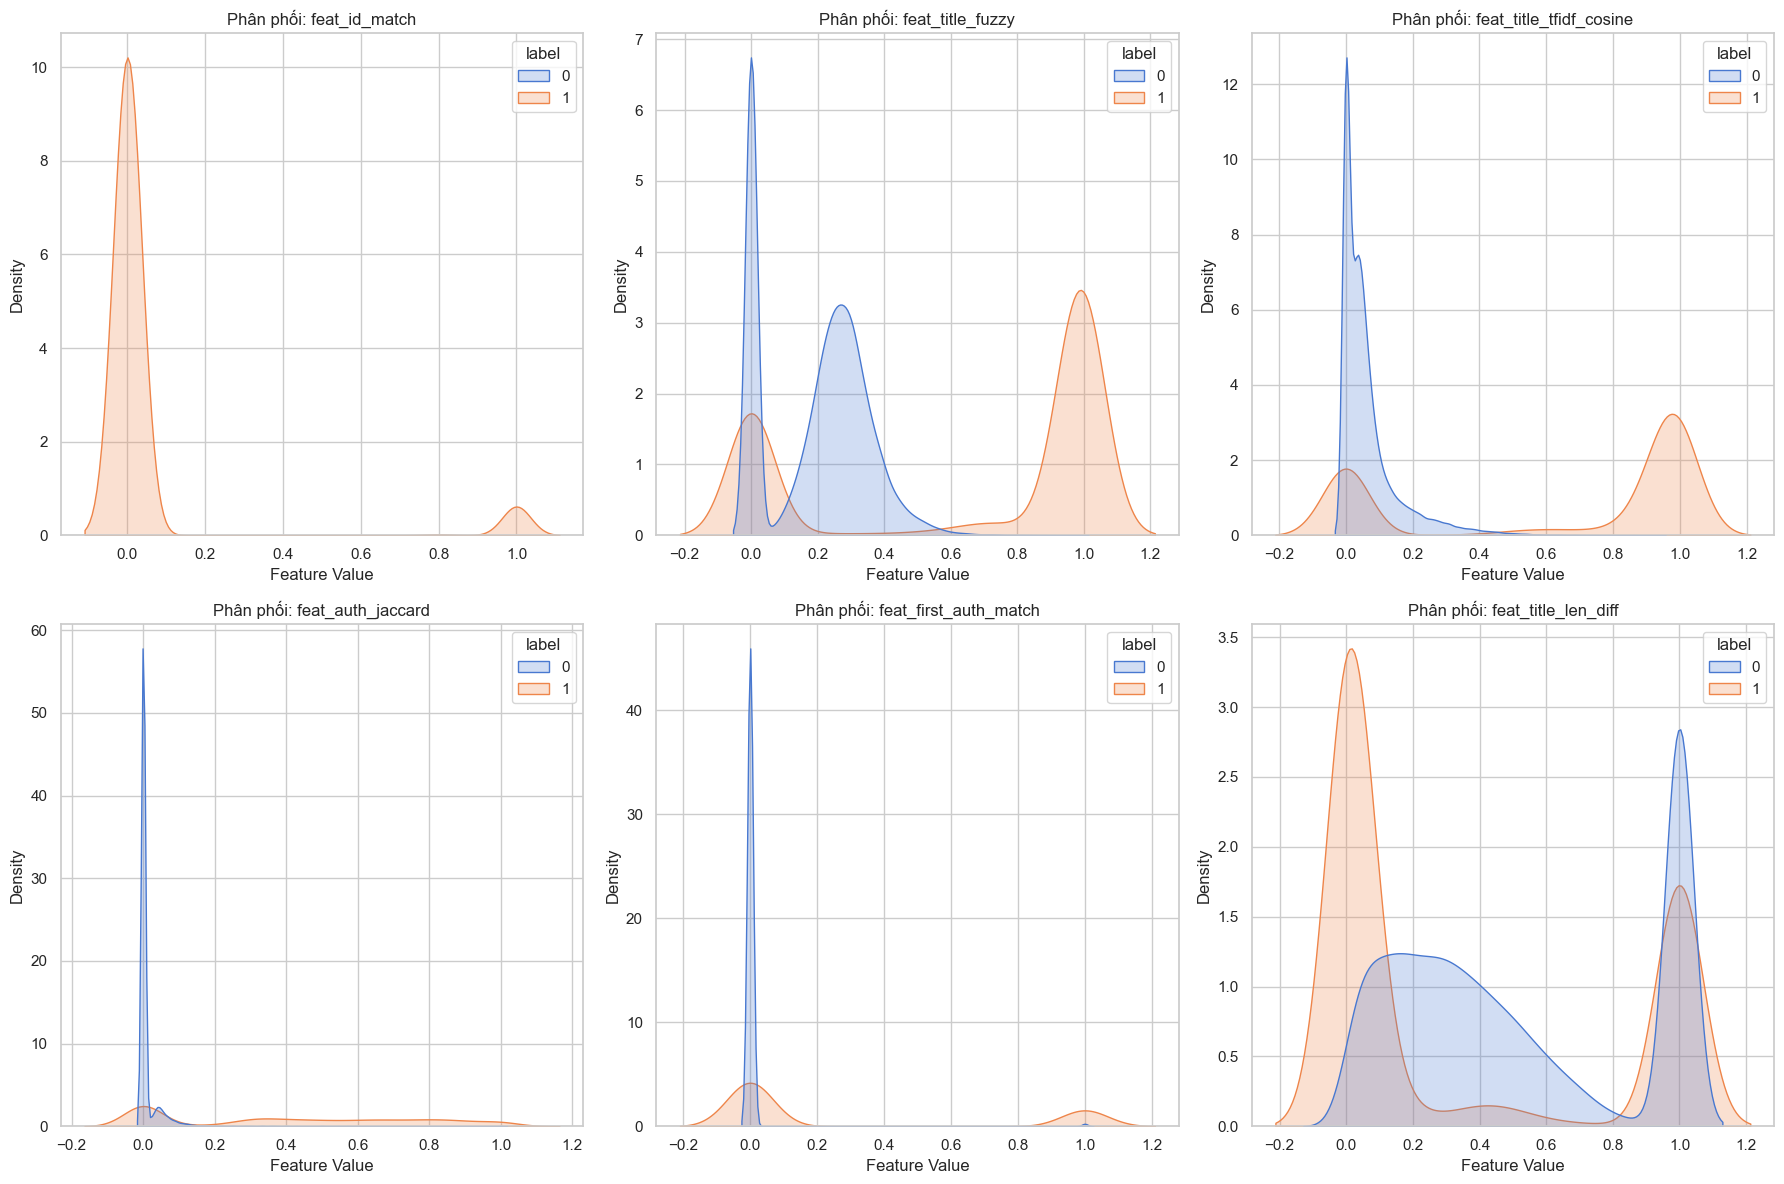

In [17]:

import matplotlib.pyplot as plt
import seaborn as sns

# Cấu hình giao diện
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (18, 12)

# Chọn các feature quan trọng để vẽ
# Bạn có thể thêm bớt tùy ý
key_features = [
    'feat_id_match', 
    'feat_title_fuzzy', 
    'feat_title_tfidf_cosine', 
    'feat_auth_jaccard', 
    'feat_first_auth_match',
    'feat_title_len_diff'
]

fig, axes = plt.subplots(2, 3)
axes = axes.flatten()

for i, col in enumerate(key_features):
    if col not in df_features.columns: continue
    sns.kdeplot(data=df_features, x=col, hue='label', fill=True, ax=axes[i], common_norm=False)
    
    axes[i].set_title(f"Phân phối: {col}")
    axes[i].set_xlabel("Feature Value")
    axes[i].set_ylabel("Density")

plt.tight_layout()
plt.show()



### Correlation Heatmap
Kiểm tra sự tương quan giữa các feature. Nếu 2 feature tương quan quá cao (>0.9), có thể cân nhắc bỏ bớt 1 cái để giảm nhẹ mô hình.


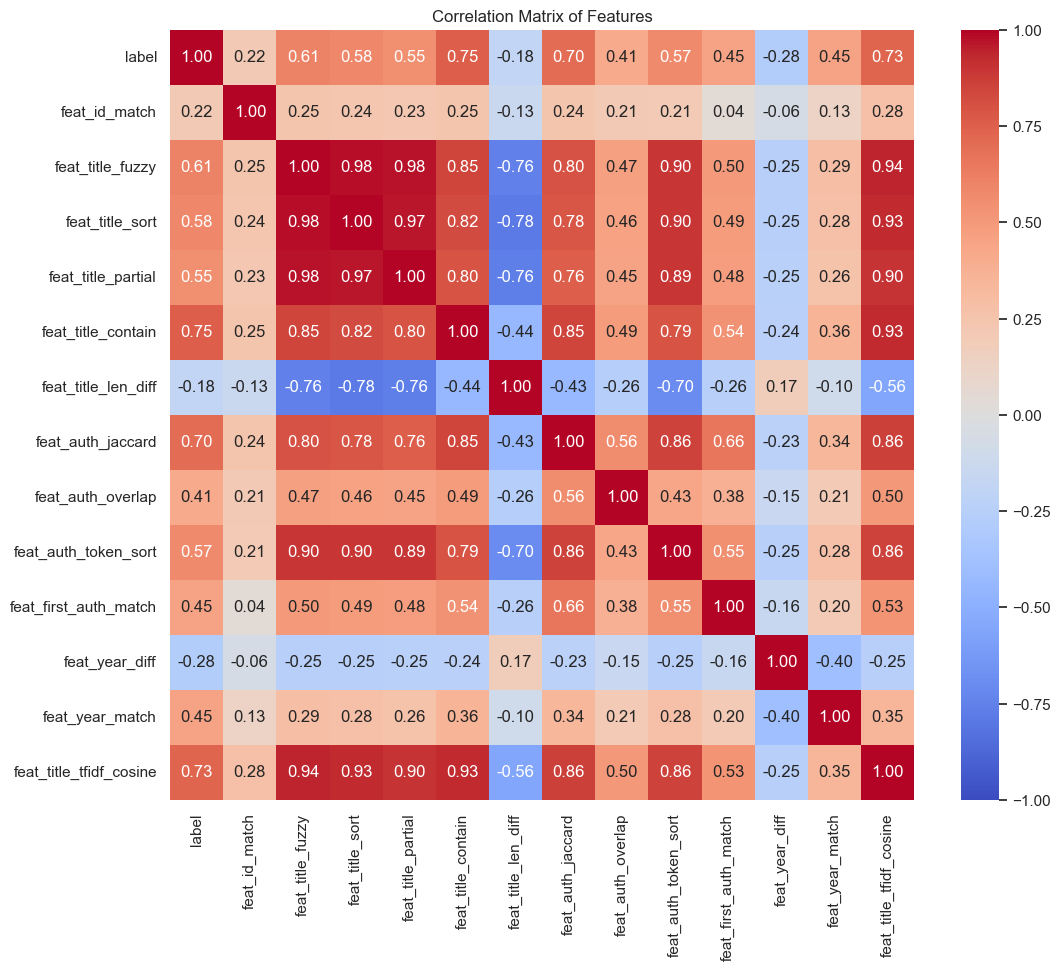

In [18]:

plt.figure(figsize=(12, 10))
corr_matrix = df_features[['label'] + feature_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Features")
plt.show()


### 1. Chất lượng Dữ liệu sau làm sạch (Post-Cleaning Quality)

Dựa trên biểu đồ phân phối, quy trình làm sạch (Cleaning Pipeline) đã đạt hiệu quả cao:

* **Title (Tiêu đề):** Phân phối điểm tương đồng lệch hẳn về phía **90-100**, cho thấy việc giải mã LaTeX (`LatexNodes2Text`) đã loại bỏ hầu hết nhiễu. Dữ liệu đầu vào rất sạch (5625 mẫu không còn ký tự rác).
* **Author (Tác giả):** Điểm số phân tán rộng, phản ánh độ khó trong việc khớp tên (viết tắt, đảo tự, "et al."). Điều này đòi hỏi các features phức tạp hơn so với string matching đơn thuần.
* **ID (Golden Key):** Phần lớn dữ liệu thiếu ID trích xuất (Missing Extracted ID), nhưng số lượng khớp sai (Mismatch) cực thấp. ID đóng vai trò là feature có **độ chính xác cao (High Precision)** nhưng độ phủ thấp (Low Recall).

### 2. Đánh giá Đặc trưng (Feature Importance Analysis)

Dựa trên ma trận tương quan (Correlation Matrix) với biến mục tiêu (`label`):

* **Feature mạnh nhất:** `feat_title_tfidf_cosine` có tương quan cao nhất (**0.75**), vượt trội hơn so với `feat_title_fuzzy` (0.61). Điều này chứng tỏ **TF-IDF** bắt được các từ khóa quan trọng (ngữ nghĩa) tốt hơn so với so khớp ký tự đơn thuần.
* **Feature bất ngờ:** `feat_auth_jaccard` đạt tương quan rất tốt (**0.68**), cho thấy dù dữ liệu Author thô khá lộn xộn, nhưng độ đo Jaccard vẫn phân biệt cực tốt giữa cặp đúng và cặp sai.
* **Vấn đề đa cộng tuyến:** Các feature thuộc nhóm Title (`fuzzy`, `sort`, `partial`) có tương quan nội bộ rất cao (>0.95). Tuy nhiên, các mô hình cây quyết định (Tree-based) có thể xử lý tốt vấn đề này.

### 💡 Kết luận & Định hướng

* Dữ liệu đã sẵn sàng cho bước **Modeling**.
* Nên sử dụng các mô hình như **XGBoost** hoặc **Random Forest** để tận dụng sức mạnh của feature rời rạc (`id_match`) kết hợp với feature liên tục (`tfidf`).
* Feature `id_match` dù có hệ số tương quan thấp (0.22) do tính thưa (sparsity), nhưng là yếu tố quyết định ("kẻ hủy diệt") cho các trường hợp khó mà Text Matching thất bại.